Поиск априрного отрезка неопределенности. 
Реализация методов для поиска минимума у заданной в виде полинома функции: 
* деления отрезка пополам:
    * двухточечный;
    * трехточечный;
* золотого сечения.

In [1]:
import numpy as np
import re
import logging
from matplotlib import pylab as plt

%matplotlib inline

logging.basicConfig(level=logging.DEBUG)

Задание констант.EPS = 0.0005

In [33]:
def F(X):
    return 0.5*X**2 - 10*X + 850

EPS = 0.0005
# (x**n, x**(n-1), ..., x**1, x**0)
COEFF = np.array((0.5, -10, 850), dtype=np.float32)
POLYNOM = np.poly1d(COEFF)

In [28]:
def f(x0):
    return np.polyval(POLYNOM, x0)

def plotf(interval, dX=0.01, polynom=POLYNOM):
    logging.debug(interval)
    X = np.arange(interval[0], interval[-1] + dX, dX)
    y = [f(x) for x in X]
    _ = plt.plot(X, y)
    
def get_interval(x0=0, dX=1, max_iter=1000):
    X = np.array([x0-dX, x0, x0+dX])
    y = np.array(list(map(f, X)))
    logging.debug(X)
    logging.debug(y)
    direction = 0
    
    if y[0] < y[1] > y[-1]:
        logging.warning("Non-unimodal function.")
        return ()
    elif y[0] > y[1] < y[-1]:
        logging.info("Found interval on [%s, %s]", X[0], X[-1])
        return (X[0], X[-1])
    elif y[0] > y[1] > y[-1]:
        logging.info("Growing function.")
        direction = 1
    elif y[0] < y[1] < y[-1]:
        logging.info("Decreasing function.")
        direction = -1
    
    step = 2
    for i in range(max_iter):
        x_t = X[1] + step * direction * dX
        
        f_x = f(x_t)
        f_x_prev = f(X[1])
        if f_x > f_x_prev and direction > 0:
            logging.info("Took %d iterations.", i)
            return (X[0], x_t)
        elif f_x < f_x_prev and direction < 0:
            logging.info("Took %d iterations.", i)
            return (x_t, X[0])
        elif f_x == f_x_prev:
            logging.info("Took %d iterations.", i)
            ans = [(x_t + X[1]) / 2 - dX, (x_t + X[1]) / 2 + dX]
            if ans[0] > ans[1]:
                ans[0], ans[1] = ans[1], ans[0]
            return (ans[0], ans[1])
        
        step *= 2
        X[0], X[1] = X[1], x_t
    
    logging.warning("Max iter reached.")
    return ()

DEBUG:root:[-1  0  1]
DEBUG:root:[ 860.5  850.   840.5]
INFO:root:Growing function.
INFO:root:Took 2 iterations.
DEBUG:root:(9.0, 11.0)


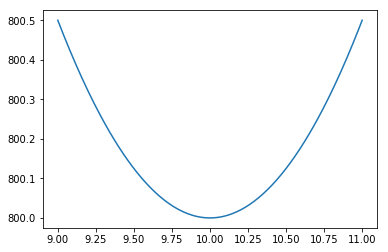

In [4]:
plotf(get_interval())

Поиск минимума.

In [5]:
def fib(q: int) -> int:
    """ Effective fibonachi. """
    return pow(2 << q, q + 1, (4 << 2 * q) - (2 << q) - 1) % (2 << q)

In [6]:
class SearchMin(object):
    @staticmethod
    def points2(interval, polynom=POLYNOM, eps=EPS, max_iter=1000, dX=0.0001):
        idx = 0
        x_a, x_b = interval[0], interval[-1]
        while abs(x_b - x_a) >= eps and idx < max_iter:
            idx += 1
            x1 = (x_a + x_b - dX) / 2
            x2 = (x_a + x_b + dX) / 2
            f1 = f(x1)
            f2 = f(x2)
            if f1 < f2:
                x_b = x2
            elif f1 > f2:
                x_a = x1
            else:
                break
        logging.info("Took %d iterations.", idx)
        return (x_a + x_b) / 2
    
    @staticmethod
    def points3(interval, polynom=POLYNOM, eps=EPS):
        x_a, x_b = interval[0], interval[1]
        idx = 0
        L = x_b - x_a
        while abs(L) >= eps:
            idx += 1
            L = x_b - x_a
            x2 = (x_a + x_b) / 2
            f2 = f(x2)
            x1 = x_a + L / 4
            f1 = f(x1)
            x3 = x_b - L / 4
            f3 = f(x3)

            if f1 < f2:
                x_b = x2
                x2 = x1
            else:
                if f2 > f3:
                    x_a = x2
                    x2 = x3
                else:
                    x_a = x1
                    x_b = x3
            L = x_b - x_a
        logging.info("Took %d iterations.", idx)
        return (x_a + x_b) / 2

    @staticmethod
    def golden_ratio(interval, polynom=POLYNOM, eps=EPS):
        x_a, x_b = interval[0], interval[1]
        phi = (1 + np.sqrt(5)) / 2
        idx = 0
        while abs(x_b - x_a) >= eps:
            idx += 1
            x1 = x_b - (x_b - x_a) / phi
            x2 = x_a + (x_b - x_a) / phi
            y1, y2 = f(x1), f(x2)
            if y1 >= y2:
                x_a = x1
            else:
                x_b = x2
        logging.info("Took %d iterations.", idx)
        return (x_a + x_b) / 2
    
    @staticmethod
    def fibonacci(interval, polynom=POLYNOM, n=30):
        idx = n
        x_a, x_b = interval[0], interval[1]
        x1 = x_a + (x_b - x_a) * (fib(n - 2) / fib(n))
        x2 = x_a + (x_b - x_a) * (fib(n - 1) / fib(n))
        y1, y2 = f(x1), f(x2)
        while n > 1:
            if y1 > y2:
                x_a = x1
                x1 = x2
                x2 = x_b - (x1 - x_a)
                y1 = y2
                y2 = f(x2)
            else:
                x_b = x2
                x2 = x1
                x1 = x_a + (x_b - x2)
                y2 = y1
                y1 = f(x1)
            n = n - 1
        logging.info("Took %d iterations.", idx)
        return (x1 + x2) / 2

In [7]:
SearchMin.points2(get_interval())

DEBUG:root:[-1  0  1]
DEBUG:root:[ 860.5  850.   840.5]
INFO:root:Growing function.
INFO:root:Took 2 iterations.
INFO:root:Took 1 iterations.


10.0

In [8]:
SearchMin.points3(get_interval())

DEBUG:root:[-1  0  1]
DEBUG:root:[ 860.5  850.   840.5]
INFO:root:Growing function.
INFO:root:Took 2 iterations.
INFO:root:Took 12 iterations.


10.0

In [9]:
SearchMin.golden_ratio(get_interval())

DEBUG:root:[-1  0  1]
DEBUG:root:[ 860.5  850.   840.5]
INFO:root:Growing function.
INFO:root:Took 2 iterations.
INFO:root:Took 18 iterations.


10.0

In [10]:
SearchMin.fibonacci(get_interval())

DEBUG:root:[-1  0  1]
DEBUG:root:[ 860.5  850.   840.5]
INFO:root:Growing function.
INFO:root:Took 2 iterations.
INFO:root:Took 30 iterations.


9.9999987984458905

Метод интерполяции Лагранжа.

In [11]:
def lagranz(x,y,t):
    z=0
    for j in range(len(y)):
        p1=1; p2=1
        for i in range(len(x)):
            if i==j:
                p1=p1*1; p2=p2*1   
            else: 
                p1=p1*(t-x[i])
                p2=p2*(x[j]-x[i])
        z=z + y[j] * p1 / p2
    return z

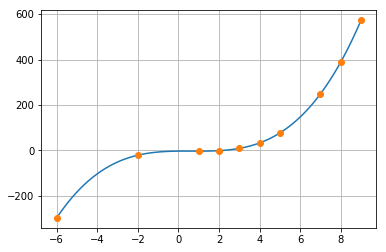

In [12]:
x= np.array([2, 5, -6, 7, 4, 3, 8, 9, 1, -2], dtype=float)
y= np.array([-1, 77, -297, 249, 33, 9, 389, 573, -3, -21], dtype=float)

xnew=np.linspace(np.min(x),np.max(x),100)
ynew=[lagranz(x, y, i) for i in xnew]
_ = plt.plot(xnew, ynew, '-', x, y, 'o')
_ = plt.grid(True)
_ = plt.show()

[Метод оптимизации Trust-Region DOGLEG](https://habrahabr.ru/post/335224/)

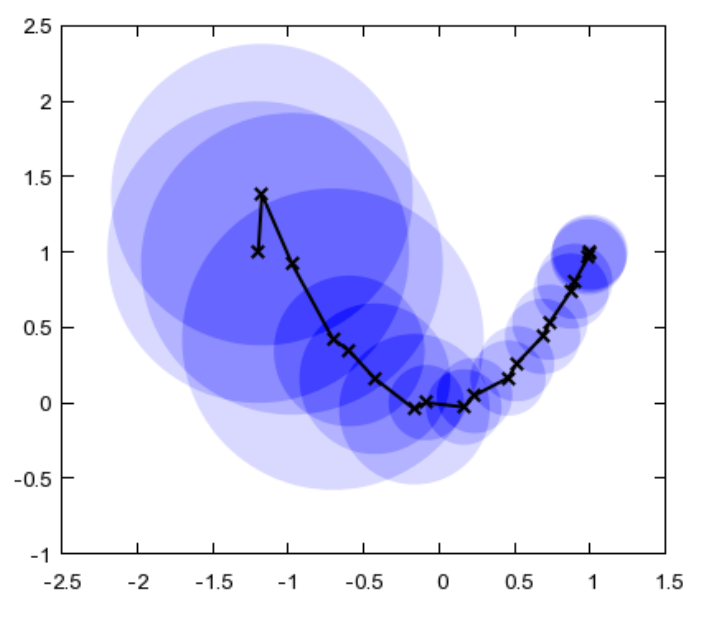

In [13]:
import numpy.linalg as ln
import scipy as sp
from math import sqrt

# Objective function    
def f(x):
    return (1-x[0])**2 + 100*(x[1]-x[0]**2)**2
# Gradient
def jac(x):
    return np.array([-400*(x[1] - x[0]**2)*x[0] - 2 + 2*x[0], 200*x[1] - 200*x[0]**2])
# Hessian
def hess(x):
    return np.array([[1200*x[0]**2 - 400*x[1]+2, -400*x[0]], [-400*x[0], 200]])
    
def dogleg_method(Hk, gk, Bk, trust_radius):
    # Compute the Newton point.
    # This is the optimum for the quadratic model function.
    # If it is inside the trust radius then return this point.
    pB = -np.dot(Hk, gk)
    norm_pB = sqrt(np.dot(pB, pB))

    # Test if the full step is within the trust region.
    if norm_pB <= trust_radius:
        return pB
    
    # Compute the Cauchy point.
    # This is the predicted optimum along the direction of steepest descent.
    pU = - (np.dot(gk, gk) / np.dot(gk, np.dot(Bk, gk))) * gk
    dot_pU = np.dot(pU, pU)
    norm_pU = sqrt(dot_pU)

    # If the Cauchy point is outside the trust region,
    # then return the point where the path intersects the boundary.
    if norm_pU >= trust_radius:
        return trust_radius * pU / norm_pU

    # Find the solution to the scalar quadratic equation.
    # Compute the intersection of the trust region boundary
    # and the line segment connecting the Cauchy and Newton points.
    # This requires solving a quadratic equation.
    # ||p_u + tau*(p_b - p_u)||**2 == trust_radius**2
    # Solve this for positive time t using the quadratic formula.
    pB_pU = pB - pU
    dot_pB_pU = np.dot(pB_pU, pB_pU)
    dot_pU_pB_pU = np.dot(pU, pB_pU)
    fact = dot_pU_pB_pU**2 - dot_pB_pU * (dot_pU - trust_radius**2)
    tau = (-dot_pU_pB_pU + sqrt(fact)) / dot_pB_pU
    
    # Decide on which part of the trajectory to take.
    return pU + tau * pB_pU
    

def trust_region_dogleg(func, jac, hess, x0, initial_trust_radius=1.0,
                        max_trust_radius=100.0, eta=0.15, gtol=1e-4, 
                        maxiter=100):
    xk = x0
    trust_radius = initial_trust_radius
    k = 0
    while True:
      
        gk = jac(xk)
        Bk = hess(xk)
        Hk = np.linalg.inv(Bk)
        
        pk = dogleg_method(Hk, gk, Bk, trust_radius)
       
        # Actual reduction.
        act_red = func(xk) - func(xk + pk)
        
        # Predicted reduction.
        pred_red = -(np.dot(gk, pk) + 0.5 * np.dot(pk, np.dot(Bk, pk)))
        
        # Rho.
        rhok = act_red / pred_red
        if pred_red == 0.0:
            rhok = 1e99
        else:
            rhok = act_red / pred_red
            
        # Calculate the Euclidean norm of pk.
        norm_pk = sqrt(np.dot(pk, pk))
        
        # Rho is close to zero or negative, therefore the trust region is shrunk.
        if rhok < 0.25:
            trust_radius = 0.25 * norm_pk
        else: 
        # Rho is close to one and pk has reached the boundary of the trust region, therefore the trust region is expanded.
            if rhok > 0.75 and norm_pk == trust_radius:
                trust_radius = min(2.0*trust_radius, max_trust_radius)
            else:
                trust_radius = trust_radius
        
        # Choose the position for the next iteration.
        if rhok > eta:
            xk = xk + pk
        else:
            xk = xk
            
        # Check if the gradient is small enough to stop
        if ln.norm(gk) < gtol:
            break
        
        # Check if we have looked at enough iterations
        if k >= maxiter:
            break
        k = k + 1
    return xk

In [14]:
result = trust_region_dogleg(f, jac, hess, [5, 5])
print("Доверительный интервал: {}".format(result))
print("Значение функции в точке: {}".format(f(result)))

Доверительный интервал: [ 1.  1.]
Значение функции в точке: 3.1012094336501027e-29


### Метод квадратичной интерполяции

In [56]:
class QuadraticInterpolation:
    def __init__(self, f: object, interval: list, eps: float=0.0005, coef: float=10) -> None:
        """
            :param interval - (min, max)
            :param coef - influences on initial approximation
        """
        self.f = f
        self.x_a, self.x_b = interval
        self.eps = eps
        self.x0 = (self.x_b - self.x_a) / 2 + (self.x_b - self.x_a) / 6.5 + self.x_a
        self.ans = None
        
    def plot(self, step: int=0.001) -> None:
        x = np.arange(self.x_a, self.x_b, step, dtype=np.float)
        y = self.f(x)
        _ = plt.plot(x, y)
    
    def step(self) -> float or None:
        if self.ans:
            return self.ans
        X0 = np.array([self.x_a, self.x0, self.x_b])
        X = np.stack((X0**2, X0, X0**0), axis=1)
        Y = self.f(X0)
        diff = np.linalg.solve(X, Y)
        x_min = - diff[1]/(2*diff[0])
        if x_min < self.x0:
            if self.f(x_min) < self.f(self.x0):
                self.x_b, self.x0 = self.x0, x_min
            else:
                self.x_a = x_min
        else:
            if self.f(x_min) < self.f(self.x0):
                self.x_a, self.x0 = self.x0, x_min
            else:
                self.x_b = x_min
        if abs(x_min - self.x0) <= self.eps:
            self.ans = x_min
    
    def find(self, max_iter: int=10000) -> float:
        idx = 0
        while self.step() is None:
            idx += 1
            if idx >= max_iter:
                break
        logging.info("Took %d iterations.", idx)
        return self.ans

In [57]:
qinterp = QuadraticInterpolation(F, get_interval())
# qinterp.plot()
qinterp.find()

DEBUG:root:[-1  0  1]
DEBUG:root:[ 860.5  850.   840.5]
INFO:root:Growing function.
INFO:root:Took 2 iterations.
INFO:root:Took 1 iterations.


9.9999999999999982